# Practice

In [91]:
import fastf1
import fastf1.plotting
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from openpyxl.styles import PatternFill
from openpyxl import Workbook
from openpyxl import load_workbook
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.offsetbox as offsetbox
from scipy import stats

In [127]:
ses = 2
race = 16

In [128]:
session = fastf1.get_session(2023,race,ses)
session.load()


logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	No cached data found for season_schedule. Loading data...
_api           INFO 	Fetching season schedule...


req            INFO 	Data has been written to cache!
core           INFO 	Loading data for Singapore Grand Prix - Practice 2 [v3.1.2]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api     

In [143]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)

# enabling misc_mpl_mods will turn on minor grid lines that clutters the plot
fastf1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False)

compoundcolor = pd.DataFrame.from_dict(
    {
        1: ['HARD','#F0F0EC'], 
        2:['INTERMEDIATE', '#43B02A'], 
        3:['MEDIUM','#FFD12E'], 
        4:['SOFT', '#DA291C'], 
        5:['TEST-UNKNOWN', '#434649'], 
        6:['UNKNOWN','#00FFFF'], 
        7:['WET', '#0067AD']
    },
    orient='index',
    columns=['Compound', 'CompoundColor']
)

In [130]:
# getting laps of session
laps = session.laps 

# adding lap time in seconds
laps['LapTimeS'] = laps["LapTime"].dt.total_seconds()

# adding lap time start in seconds
laps['LapStartTimeS'] = laps["LapStartTime"].dt.total_seconds()

# adding lap time end in seconds
laps['DeltaTime'] = 0 # add column Delta time filled with 0

# getting max lap of session
max_lap = int(session.laps["LapNumber"].max())

#results of race
results = session.results
results = results.sort_values(by=['Position'])

#correcting team color
results["TeamColor"] = [fastf1.plotting.team_color(i) for i in results["TeamName"]] 

# drivers list
drivers = results["DriverNumber"].values

# Drivers Start order 
drivers_start = results[["DriverNumber","GridPosition"]].sort_values(by=['GridPosition'])
drivers_start = drivers_start["DriverNumber"].values

#drivers abreviation
drivers_abr = [session.get_driver(driver)["Abbreviation"] for driver in drivers]

# Drivers Start order 
drivers_start_abr = results[["Abbreviation","GridPosition"]].sort_values(by=['GridPosition'])
drivers_start_abr = drivers_start_abr["Abbreviation"].values

#race name 
race_name = session.event["EventName"]

### gap fastest lap 

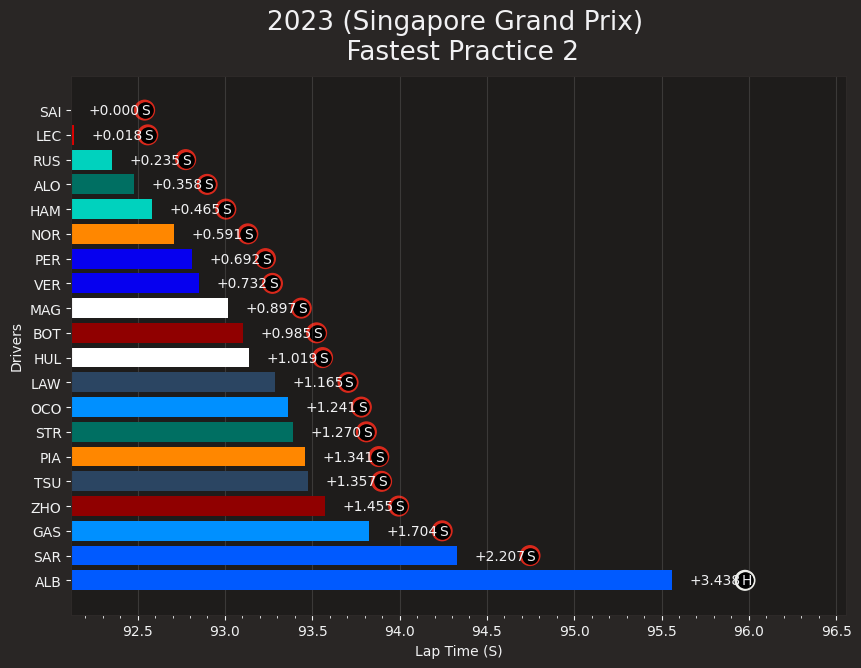

In [131]:
laps_practice = laps.pick_quicklaps()
practice_results = pd.DataFrame()
for i in drivers:
    lap = laps_practice.pick_driver(i).pick_fastest()
    practice_results = pd.concat([practice_results, pd.DataFrame(lap).T.reset_index(drop=True)], ignore_index=True)

# calculate gap to P1
practice_results['LapTimeS'] = practice_results['LapTimeS'].fillna(practice_results["LapTimeS"].min())
practice_results["DeltaTime"] = practice_results["LapTimeS"]-practice_results["LapTimeS"].min()
practice_results = pd.merge(practice_results, results[["DriverNumber","TeamColor"]], on='DriverNumber')
practice_results = pd.merge(practice_results, compoundcolor[["Compound","CompoundColor"]], on='Compound')
practice_results = practice_results.sort_values(by=['LapTimeS']).reset_index(drop=True)

#Plotting Practice Results

plt.figure(figsize=(10, 7))

# Load your logo image (replace 'logo.png' with the actual filename)
# logo = plt.imread('logo/LogoFomulaRcmDark.png')

y = practice_results["Driver"]
x = practice_results["LapTimeS"]
minx = practice_results["LapTimeS"].min()
maxx = practice_results["LapTimeS"].max()
# Create the horizontal bar plot
plt.barh(y,x , color = practice_results["TeamColor"])
plt.scatter(x+0.42,y , color = practice_results["CompoundColor"], marker='o', s=200, zorder=0)
plt.scatter(x+0.42,y , color = "Black", marker='o', s=120, zorder=0)

# Set labels and title
plt.xlabel('Lap Time (S)')
plt.ylabel('Drivers')
plt.title('2023 ('+session.event["EventName"]+') \n Fastest '+session.event["Session"+str(ses)])
plt.xticks(range(80, 95, 1))
plt.xlim(minx, maxx+1)
plt.gca().invert_yaxis()
# Set the y-axis ticker to display integer values with increments of 0.1
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=0.1))

plt.grid(axis='x',alpha = 0.2)


# Add text annotations near each bar
for i in range(0,len(y)):
    plt.text(practice_results["LapTimeS"][i] + 0.1, i, "+"+"{:.3f}".format(practice_results["DeltaTime"][i]), va='center')
    plt.text(practice_results["LapTimeS"][i] + 0.4, i,practice_results["Compound"][i][0], va='center')

# Display the plot
plt.savefig('C:/Users/GTR/Pictures/Graphes/Practice/Results_'+session.event["Session"+str(ses)]+'.png', dpi=200, bbox_inches='tight')

plt.show()

### Graph Pace Practice

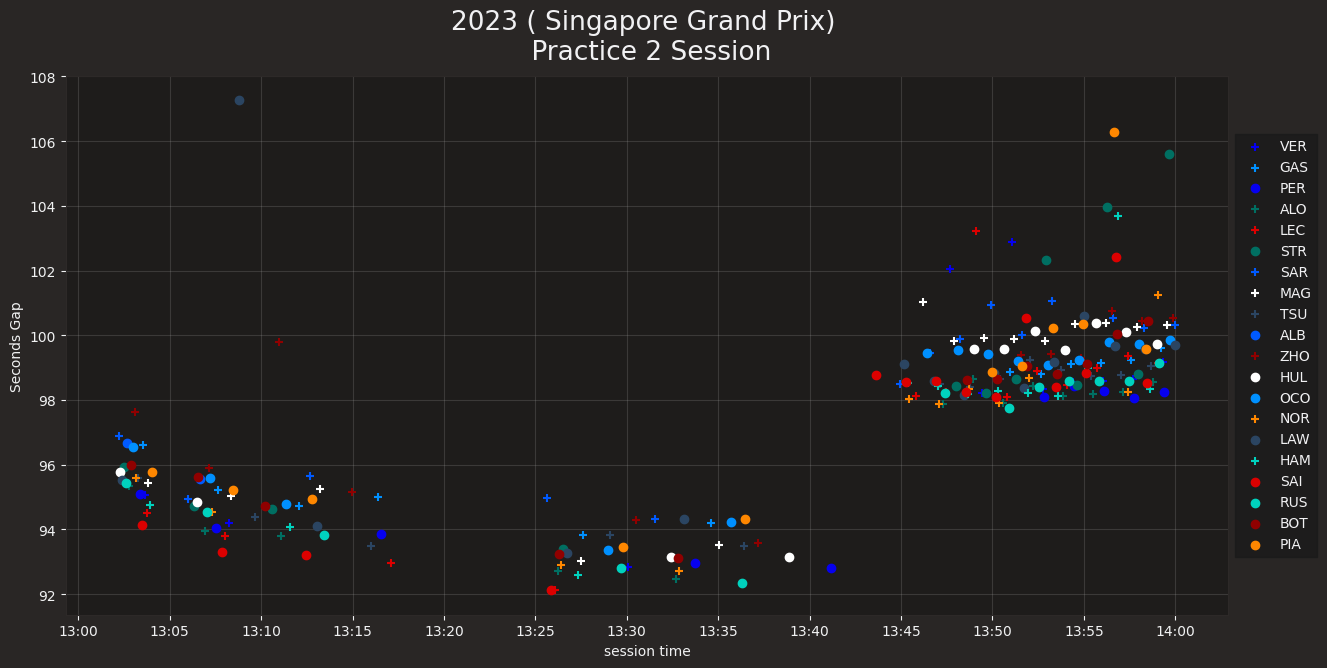

In [132]:
laps_session = session.laps.pick_wo_box()
laps_session = laps_session[["DriverNumber","Driver","LapNumber","LapStartDate","Compound","LapTime","TyreLife","Stint"]]
laps_session["LapTimeS"] = laps_session["LapTime"].dt.total_seconds()
laps_session["LapStartDate"] = pd.to_datetime(laps_session["LapStartDate"])
laps_session["LapStartDateM"] = laps_session["LapStartDate"].dt.strftime('%H:%M')
laps_session = pd.merge(laps_session, compoundcolor, on='Compound')

# ploting the lap time

plt.figure(figsize=(15, 7))
color_picked = []
# for i in ['1','11','16','44','55','63','81','4','14']:
for i in drivers:
    lap_ordred = laps_session.loc[laps_session["DriverNumber"] == i].sort_values(by='LapStartDateM', ascending=True)
    lap_ordred = lap_ordred.loc[lap_ordred["LapTimeS"] <= 110]
    x = lap_ordred["LapStartDate"]
    y = lap_ordred["LapTimeS"]

    driver_name = session.get_driver(i)["Abbreviation"]
    team_color =  fastf1.plotting.team_color(session.get_driver(i)["TeamName"])
    
    if team_color in color_picked:
        plt.scatter(x, y, color=team_color, marker='o', label=driver_name)
    else:    
        plt.scatter(x, y, color=team_color, marker='+', label=driver_name)
        color_picked.append(team_color)
# Set the x-axis formatter
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

# Set the x-axis locator
locator = mdates.MinuteLocator(interval=5)
plt.gca().xaxis.set_major_locator(locator)

# Customize the plot
plt.title('2023 ( '+session.event["EventName"]+') \n Practice '+str(ses)+' Session')
plt.xlabel('session time')
plt.ylabel('Seconds Gap')

# plt.yticks(range(min_lap_time, max_lap_time, 1))

plt.grid(True, alpha=0.2)

# Add legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Display the plot
plt.show()


### Table pace 

In [133]:
# data_time = pd.DataFrame()
# data_time ["lapNumber"] = [i for i in range(1, max_lap+1)]
# data_comp = pd.DataFrame()
# data_comp ["lapNumber"] = [i for i in range(1, max_lap+1)]

In [134]:
# for i in drivers:
#     data_time [session.get_driver(i)['Abbreviation']] = laps.loc[laps["DriverNumber"]==i,["LapTimeMinute"]].reset_index(drop=True)
#     data_comp [session.get_driver(i)['Abbreviation']] = laps.loc[laps["DriverNumber"]==i,["Compound"]].reset_index(drop=True)

In [135]:
# df = pd.DataFrame(data_time)

# df.to_excel('Session_lap_time.xlsx', index=False)
# # Charger le fichier Excel existant
# fichier_excel = 'Session_lap_time.xlsx'
# classeur = load_workbook(fichier_excel)

# # Sélectionner la feuille active
# feuille = classeur.active

# for j in range(1,data_time.shape[1]):
#     for i in range(0,data_time.shape[0]):
#         compound = data_comp.iloc[i,j]
#         if(compound == "HARD"):
#             couleur = compound_color["HARD"]
#         elif(compound == "MEDIUM"):
#             couleur = compound_color["MEDIUM"]
#         elif(compound == "SOFT"):
#             couleur = compound_color["SOFT"]
#         else:
#             couleur = 'FFFFFF'
#         cellule = feuille.cell(row=i+2, column=j+1)
#         cellule.fill = PatternFill(start_color=couleur, end_color=couleur, fill_type='solid')

# # Enregistrer les modifications dans le fichier Excel
# classeur.save(fichier_excel)

### Top Speed in session

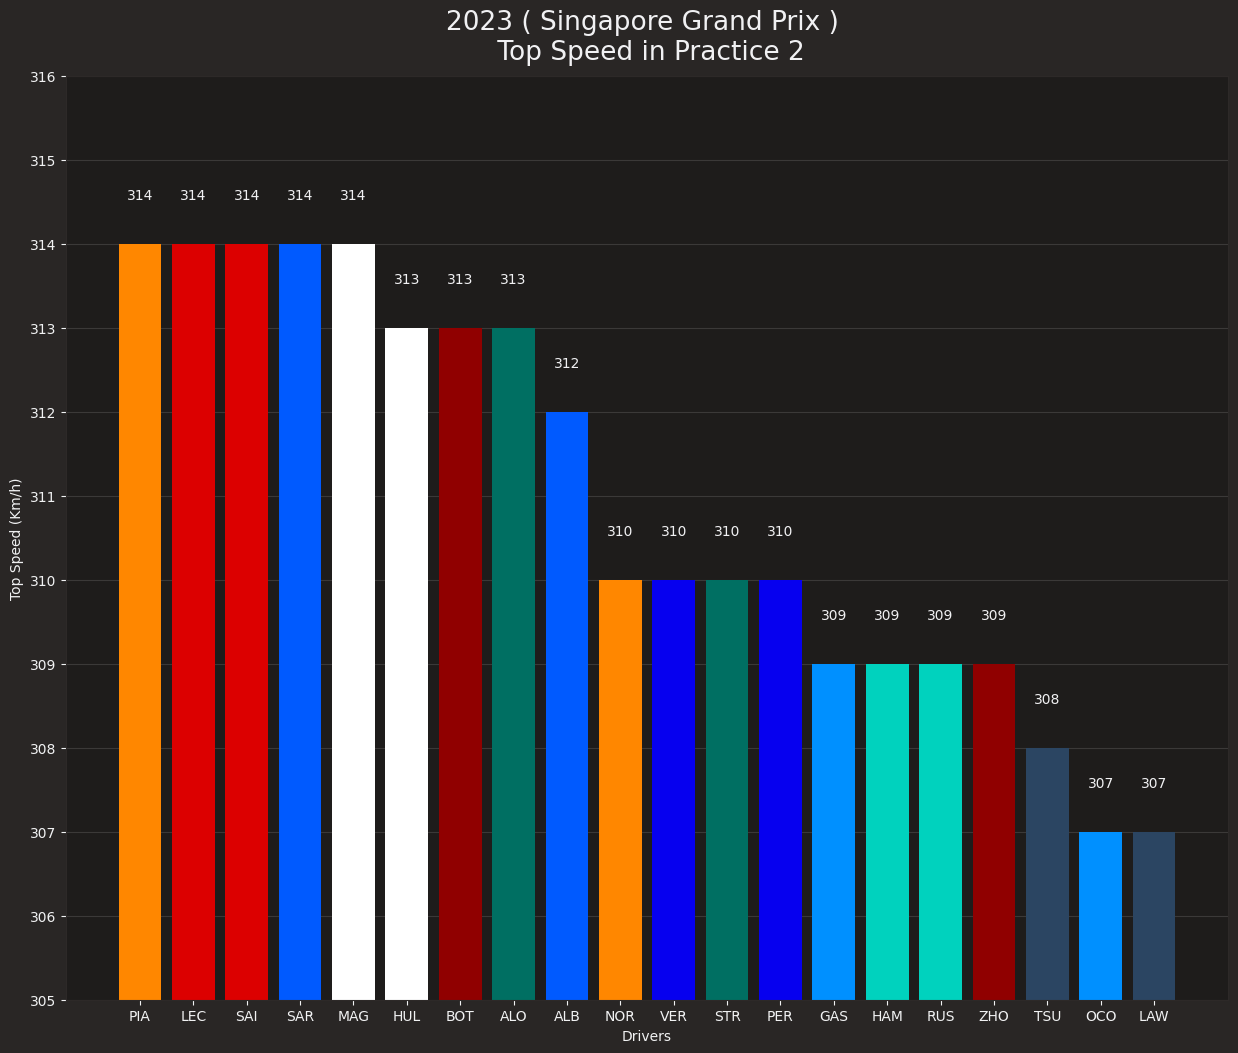

In [136]:
driver_list = []
DriverAB_list = []
top_speed_list = []
color_list = []

for i in drivers:
    if laps.pick_driver(i).empty:
        print("The DataFrame is empty")
    else:
        max_speed = laps.pick_driver(i).pick_fastest().get_car_data()
        Top_Speed = max_speed.loc[max_speed['Speed'].idxmax(),"Speed"]

        driver_list.append(i)
        DriverAB_list.append(session.get_driver(i)[["Abbreviation"]].values[0])
        top_speed_list.append(Top_Speed)
        color_list.append(fastf1.plotting.team_color(session.get_driver(i)["TeamName"]))

df_top_speed = pd.DataFrame({
    'DriverNumber': driver_list,
    'Driver': DriverAB_list,
    'TopSpeed': top_speed_list,
    'Color': color_list
})

df_top_speed = df_top_speed.sort_values(by='TopSpeed', ascending=False)

#ploting the top speed

plt.figure(figsize=(15, 12))
x = df_top_speed["Driver"].reset_index(drop=True)
y = df_top_speed["TopSpeed"].reset_index(drop=True)
max = df_top_speed["TopSpeed"].max()
min = df_top_speed["TopSpeed"].min()
# Create the bar plot
plt.bar(x, y,color = df_top_speed["Color"])

# Add labels and title
plt.xlabel('Drivers')
plt.ylabel('Top Speed (Km/h)')
plt.title('2023 ( '+session.event["EventName"]+' ) \n Top Speed in '+session.event["Session"+str(ses)])
plt.yticks(range(300, 400, 1))
plt.ylim(min-2, max+2)
# Add text annotations on top of bars
for i in range(len(x)):
    plt.text(i, y.loc[i]+0.5, str(y.loc[i]), ha='center', va='bottom')
    
plt.grid(axis='y', alpha=0.2)
# Display the plot
plt.savefig('C:/Users/GTR/Pictures/Graphes/Practice/Top_Speed_'+session.event["Session"+str(ses)]+'.png', dpi=200, bbox_inches='tight')
plt.show()

### Low Speed

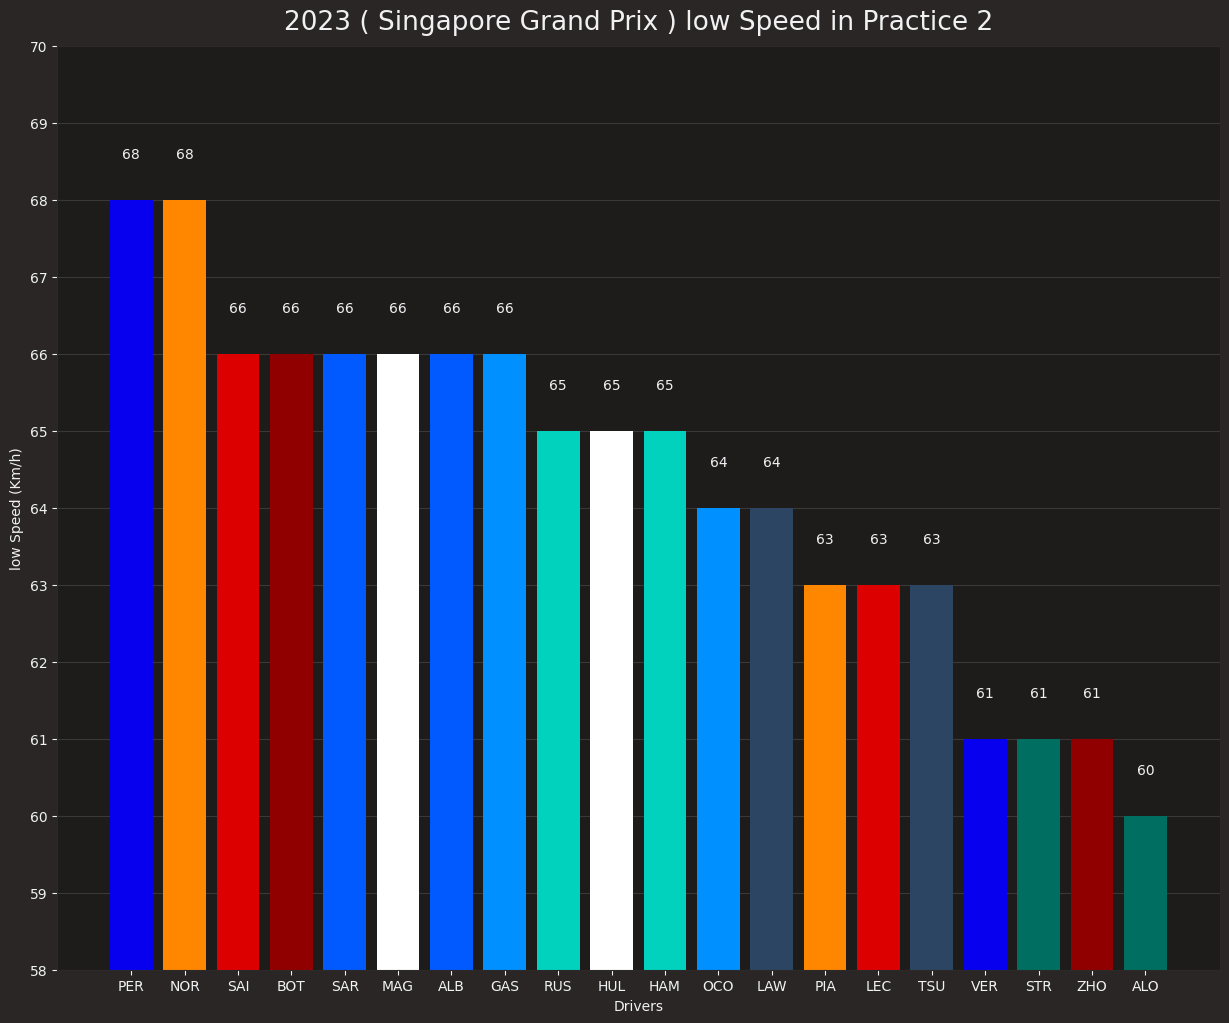

In [137]:
driver_list = []
DriverAB_list = []
low_speed_list = []
color_list = []

for i in drivers:
    if laps.pick_driver(i).empty:
        print("The DataFrame is empty")
    else:
        min_speed = laps.pick_driver(i).pick_fastest().get_car_data()
        low_Speed = min_speed.loc[min_speed['Speed'].idxmin(),"Speed"]

        driver_list.append(i)
        DriverAB_list.append(session.get_driver(i)[["Abbreviation"]].values[0])
        low_speed_list.append(low_Speed)
        color_list.append(fastf1.plotting.team_color(session.get_driver(i)["TeamName"]))

df_low_speed = pd.DataFrame({
    'DriverNumber': driver_list,
    'Driver': DriverAB_list,
    'lowSpeed': low_speed_list,
    'Color': color_list
})
df_low_speed = df_low_speed.sort_values(by='lowSpeed', ascending=False)

# ploting the low speed

plt.figure(figsize=(15, 12))
x = df_low_speed["Driver"].reset_index(drop=True)
y = df_low_speed["lowSpeed"].reset_index(drop=True)
max = df_low_speed["lowSpeed"].max()
min = df_low_speed["lowSpeed"].min()
# Create the bar plot
plt.bar(x, y,color = df_low_speed["Color"])

# Add labels and title
plt.xlabel('Drivers')
plt.ylabel('low Speed (Km/h)')
plt.title('2023 ( '+session.event["EventName"]+' ) low Speed in '+session.event["Session"+str(ses)])
plt.yticks(range(0, 400, 1))
plt.ylim(min-2, max+2)
# Add text annotations on low of bars
for i in range(len(x)):
    plt.text(i, y.loc[i]+0.5, str(y.loc[i]), ha='center', va='bottom')
    
plt.grid(axis='y', alpha=0.2)
# Display the plot
plt.savefig('C:/Users/GTR/Pictures/Graphes/Practice/low_Speed_'+session.event["Session"+str(ses)]+'.png', dpi=200, bbox_inches='tight')
plt.show()

### Fastest Lap Average Speed

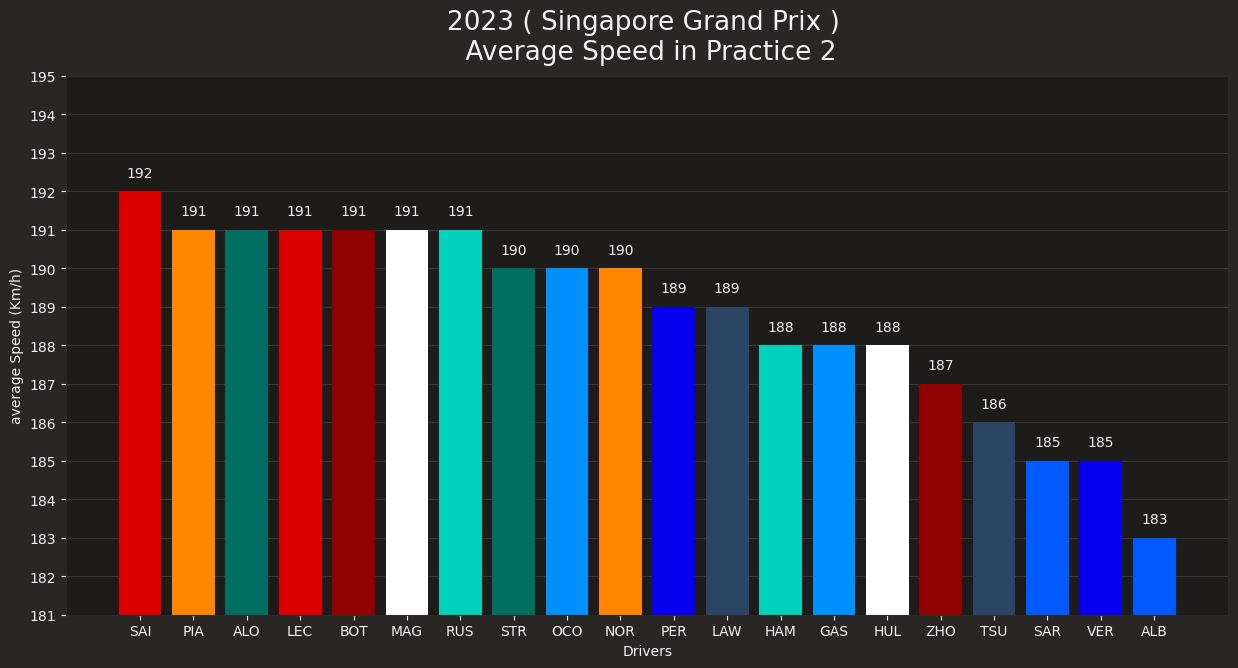

In [160]:
driver_list = []
DriverAB_list = []
avg_speed_list = []
color_list = []

for i in drivers:
    if laps.pick_driver(i).empty:
        print("The DataFrame is empty")
    else:
        max_speed = laps.pick_driver(i).pick_fastest().get_car_data()
        avg_Speed = round(max_speed["Speed"].mean())

        driver_list.append(i)
        DriverAB_list.append(session.get_driver(i)[["Abbreviation"]].values[0])
        avg_speed_list.append(avg_Speed)
        color_list.append(fastf1.plotting.team_color(session.get_driver(i)["TeamName"]))

df_avg_speed = pd.DataFrame({
    'DriverNumber': driver_list,
    'Driver': DriverAB_list,
    'AvgSpeed': avg_speed_list,
    'Color': color_list
})


df_avg_speed = df_avg_speed.sort_values(by='AvgSpeed', ascending=False)


# ploting the average speed


plt.figure(figsize=(15, 7))
x = df_avg_speed["Driver"].reset_index(drop=True)
y = df_avg_speed["AvgSpeed"].reset_index(drop=True)

# Create the bar plot
plt.bar(x, y,color = df_avg_speed["Color"])

# Add labels and title
plt.xlabel('Drivers')
plt.ylabel('average Speed (Km/h)')
plt.title('2023 ( '+session.event["EventName"]+' ) \n Average Speed in Practice '+str(ses))
plt.yticks(range(0, 250, 1))
plt.ylim(y.min()-2, y.max()+3)
# Add text annotations on top of bars
for i in range(len(x)):
    plt.text(i, y.loc[i]+0.3, str(y.loc[i]), ha='center', va='bottom')

plt.grid(axis='y', alpha=0.2)

plt.savefig('C:/Users/GTR/Pictures/Graphes/Practice/avg_Speed_'+session.event["Session"+str(ses)]+'.png', dpi=200, bbox_inches='tight')

# Display the plot
plt.show()

### table de temps 

In [147]:
table_results = practice_results[["Driver","Sector1Time","Sector2Time","Sector3Time","LapTime","DeltaTime"]].dropna()

def highlight_min(s):
    is_min = s == s.min()
    return ['color: purple' if v else '' for v in is_min]

# Apply the styling using apply()
styled_df = table_results.style.apply(highlight_min, subset=['Sector1Time','Sector2Time','Sector3Time','LapTime'])
# Define the CSS styling for the header
header_styles = [
    {'selector': 'th',
     'props': [('background-color', 'purple'), ('color', 'white')]}
]
styled_df

,Driver,Sector1Time,Sector2Time,Sector3Time,LapTime,DeltaTime
0,SAI,0 days 00:00:27.051000,0 days 00:00:38.945000,0 days 00:00:26.124000,0 days 00:01:32.120000,0.000000
1,LEC,0 days 00:00:26.972000,0 days 00:00:38.869000,0 days 00:00:26.297000,0 days 00:01:32.138000,0.018000
2,RUS,0 days 00:00:27.176000,0 days 00:00:38.879000,0 days 00:00:26.300000,0 days 00:01:32.355000,0.235000
3,ALO,0 days 00:00:27.087000,0 days 00:00:39.156000,0 days 00:00:26.235000,0 days 00:01:32.478000,0.358000
4,HAM,0 days 00:00:27.264000,0 days 00:00:39.027000,0 days 00:00:26.294000,0 days 00:01:32.585000,0.465000
5,NOR,0 days 00:00:27.028000,0 days 00:00:39.227000,0 days 00:00:26.456000,0 days 00:01:32.711000,0.591000
6,PER,0 days 00:00:27.359000,0 days 00:00:39.018000,0 days 00:00:26.435000,0 days 00:01:32.812000,0.692000
7,VER,0 days 00:00:27.295000,0 days 00:00:39.195000,0 days 00:00:26.362000,0 days 00:01:32.852000,0.732000
8,MAG,0 days 00:00:27.316000,0 days 00:00:39.319000,0 days 00:00:26.382000,0 days 00:01:33.017000,0.897000
9,BOT,0 days 00:00:27.270000,0 days 00:00:39.342000,0 days 00:00:26.493000,0 days 00:01:33.105000,0.985000


### Race pace comparison

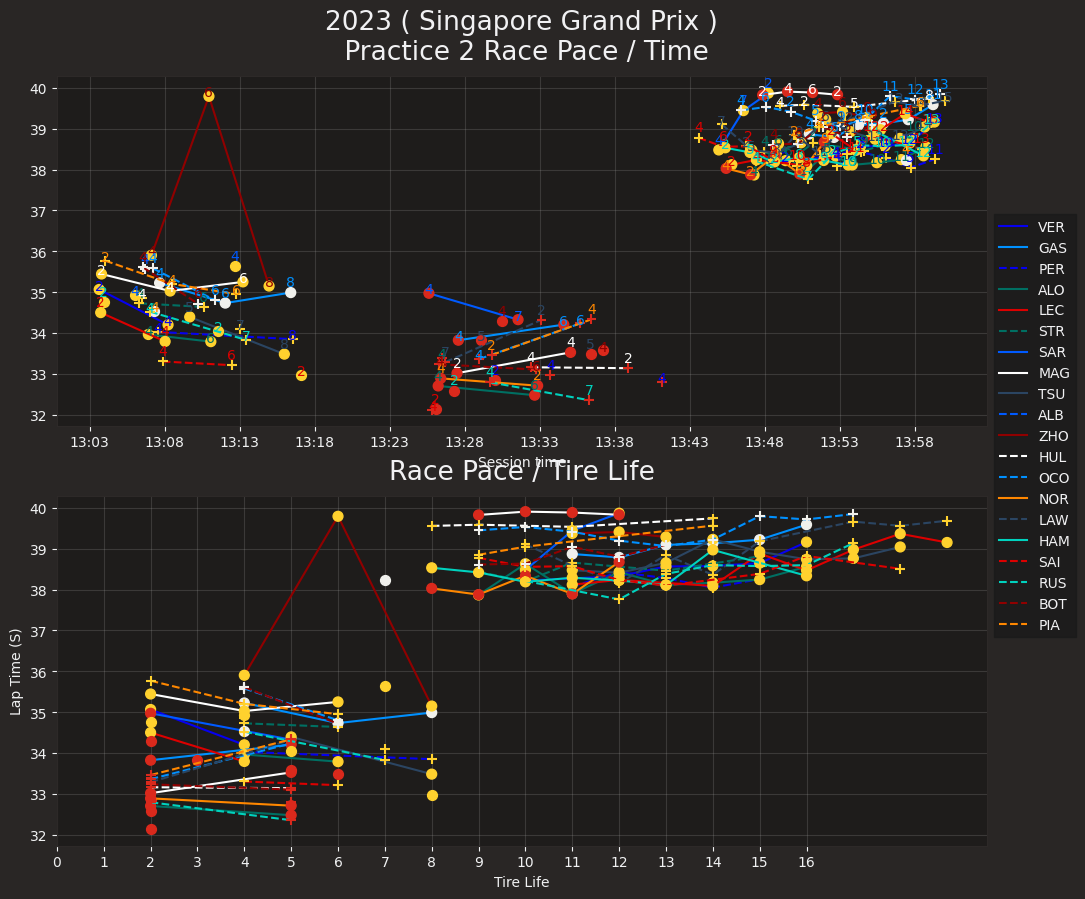

In [150]:
fig, ax = plt.subplots(2,1,figsize=(12, 10))


color_picked = []
z = 0.08
laps_session = session.laps.pick_wo_box()
laps_session = laps_session[["DriverNumber","Driver","LapNumber","LapStartDate","Compound","LapTime","TyreLife","Stint"]]
laps_session["LapTimeS"] = laps_session["LapTime"].dt.total_seconds()
laps_session["LapStartDate"] = pd.to_datetime(laps_session["LapStartDate"])
laps_session["LapStartDateM"] = laps_session["LapStartDate"].dt.strftime('%H:%M')
laps_session = pd.merge(laps_session, compoundcolor, on='Compound')
session_time = laps_session["LapStartDate"].values[0]
new_session_time = session_time + pd.Timedelta(minutes=0)

for i in drivers:
    lap_ordred = laps_session.loc[(laps_session["DriverNumber"] == i)&(laps_session["LapStartDate"] >= new_session_time)].sort_values(by='LapStartDateM', ascending=True)
    # lap_ordred = laps_session.loc[laps_session["DriverNumber"] == i].sort_values(by='LapStartDateM', ascending=True)
    # lap_ordred = lap_ordred.loc[lap_ordred["Compound"] == "SOFT"]
    lap_ordred["LapTimeS"] = lap_ordred["LapTimeS"] - 60
    lap_ordred = lap_ordred.loc[lap_ordred["LapTimeS"] <= 40]

    driver_name = session.get_driver(i)["Abbreviation"]
    team_color =  fastf1.plotting.team_color(session.get_driver(i)["TeamName"])
    for j in lap_ordred["Stint"].unique():
        x = lap_ordred.loc[lap_ordred["Stint"] == j,"LapStartDate"]
        x1 = lap_ordred.loc[lap_ordred["Stint"] == j,"TyreLife"]
        y = lap_ordred.loc[lap_ordred["Stint"] == j,"LapTimeS"]
        marker_color = lap_ordred.loc[lap_ordred["Stint"] == j,"CompoundColor"]
        z = z*-1

        if team_color in color_picked:
            ax[0].plot(x, y, color=team_color, label=driver_name, linestyle='--')
            ax[0].scatter(x, y, color=marker_color, marker='+', s=50, zorder=2)
            ax[1].plot(x1, y, color=team_color, label=driver_name, linestyle='--')
            ax[1].scatter(x1, y, color=marker_color, marker='+', s=50, zorder=2)
            # Add numeric values above each marker
            for xi, yi, label in zip(x, y+z, lap_ordred["TyreLife"]):
                ax[0].text(xi, yi, str(int(label)), ha='center', va='bottom', color=team_color)
        else:    
            ax[0].plot(x, y, color=team_color, label=driver_name)
            ax[0].scatter(x, y, color=marker_color, marker='o', s=50, zorder=2)
            ax[1].plot(x1, y, color=team_color, label=driver_name)
            ax[1].scatter(x1, y, color=marker_color, marker='o', s=50, zorder=2)   
            # Add numeric values above each marker
            for xi, yi, label in zip(x, y+z, lap_ordred["TyreLife"]):
                ax[0].text(xi, yi, str(int(label)), ha='center', va='bottom', color=team_color)
        driver_name = ""
    color_picked.append(team_color)
# Set the x-axis formatter
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
# Set the x-axis locator
locator = mdates.MinuteLocator(interval=5)
ax[0].xaxis.set_major_locator(locator)

# Customize the plot
ax[0].set_title('2023 ( '+session.event["EventName"]+' )\n Practice '+str(ses)+' Race Pace / Time')
ax[1].set_title('Race Pace / Tire Life')
ax[0].set_xlabel('Session time')
ax[1].set_xlabel('Tire Life')
ax[1].set_xticks(range(0, 17, 1))
plt.ylabel('Lap Time (S)')

# plt.yticks(range(37,40, 1))
# plt.ylim(37,40)


ax[0].grid(True, alpha=0.2)
ax[1].grid(True, alpha=0.2)


# Add legend
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0))

# Display the plot
plt.show()


In [165]:
laps1["Team"].unique()

array(['Alfa Romeo', 'Ferrari', 'Williams', 'AlphaTauri', 'Mercedes',
       'McLaren', 'Alpine', 'Aston Martin', 'Haas F1 Team',
       'Red Bull Racing'], dtype=object)

### Tire management

In [170]:
laps1["Compound"].unique()

array(['MEDIUM', 'SOFT', 'HARD'], dtype=object)

In [188]:
laps1.loc[laps1["Compound"] == 'MEDIUM',"TyreLife"].max()

19.0

19.0


C:\Users\GTR\AppData\Local\Temp\ipykernel_2140\2797404243.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps1["LapTimeSeconds"] = laps1["LapTime"].dt.total_seconds()


TypeError: 'numpy.float64' object cannot be interpreted as an integer

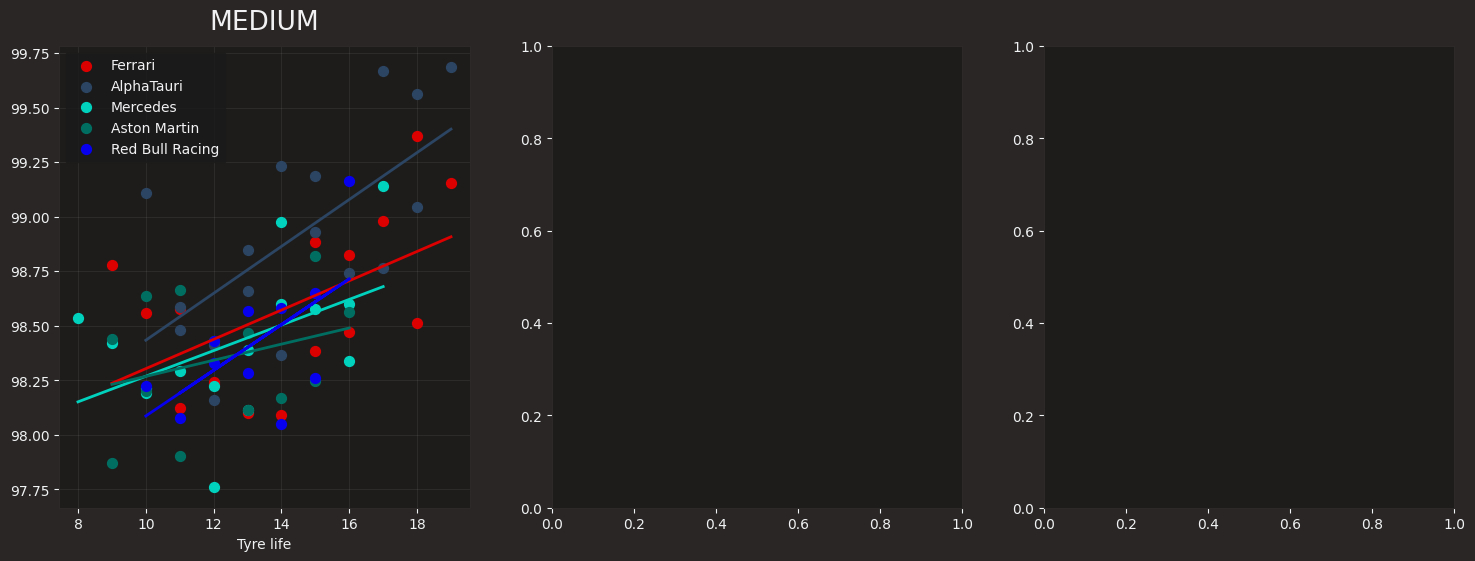

In [185]:
laps1 = session.laps.pick_wo_box()
laps1["LapTimeSeconds"] = laps1["LapTime"].dt.total_seconds()
laps1 = laps1.loc[laps1["LapStartDate"] >= session_time].sort_values(by='LapStartDate', ascending=True)
laps1 = laps1.loc[laps1["Compound"] != "TEST_UNKNOWN"].reset_index(drop=True)
laps1 = laps1.loc[(laps1["LapTimeS"] >= 97)&(laps1["LapTimeS"] <= 100)].reset_index(drop=True)



# Data for the teams
teams = laps1["Team"].unique()

# Create a figure and axis
# plt.figure(figsize=(8, 6))
# ax = plt.gca()
exist = False
fig, ax = plt.subplots(1,3,figsize=(18, 6))
j=-1
for i in laps1["Compound"].unique():
    j=j+1
    ax[j].set_title(i)
    ax[j].set_xlabel('Tyre life')
    # Loop through each team
    for team in teams:
        
        if (len(laps1.loc[(laps1["Team"] == team)&(laps1["Compound"] == i)])>5):
            exist = True
            x = laps1.loc[(laps1["Team"] == team)&(laps1["Compound"]==i), "TyreLife"]
            y = laps1.loc[(laps1["Team"] == team)&(laps1["Compound"]==i), "LapTimeS"]
            color = fastf1.plotting.team_color(team)
            # print(len(x),len(y),len(color),team,j)
            ax[j].scatter(x, y, color=color, s=50, label=team)
            
            # Perform linear regression
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            ax[j].legend()
            # Create a regression line
            regression_line = slope * x + intercept

            # Plot the regression line
            ax[j].plot(x, regression_line, color=color, linestyle='-', linewidth=2)
    max_lap = laps1.loc[laps1["Compound"] == i,"TyreLife"].max()
    print(max_lap)
    ax[j].grid(True, alpha=0.1)
    ax[j].set_xticks(range(5, -, 1))


ax[0].set_ylabel('Lap Time (S)')

plt.savefig('C:/Users/GTR/Pictures/Graphes/Practice/TiresManagment_'+session.event["Session"+str(ses)]+'.png', dpi=200, bbox_inches='tight')

plt.show()


### Tire Usage 

In [ ]:
laps = session.laps
tires = laps[["Driver","DriverNumber","Compound","TyreLife","Stint","FreshTyre"]]
tires = tires.loc[tires["TyreLife"] == 1]
tires = tires.groupby(["Driver","DriverNumber","Compound","Stint"])["TyreLife"].count().reset_index().sort_values(by=['Driver','Stint'], ascending=True)
tires = pd.merge(tires, compoundcolor, on='Compound')

In [ ]:
string_list = tires["Compound"].values
first_chars = []

for s in string_list:
    if len(s) > 0:  # Ensure the string is not empty
        first_chars.append(s[0])

tires["Abr"] = first_chars

In [ ]:
list = tires.groupby(by=["Driver",'DriverNumber'])["Stint"].count().values

In [ ]:
number = []
for i in list:
    if (i == 1):
        number.append(i)
    else:
        for j in range(1,i+1):
            number.append(j)

In [ ]:
tires["TireNumber"] = number

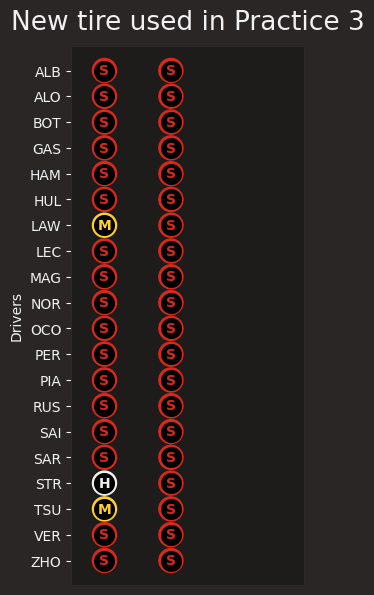

In [ ]:
plt.figure(figsize=(3,7))

x = tires["TireNumber"]
y = tires["Driver"]
color = tires["CompoundColor"]

plt.scatter(x, y, color=color, marker='o', s=300, zorder=0)
plt.scatter(x-0.006, y, color='black', marker='o', s=200, zorder=1)

for i, abr in enumerate(tires["Abr"]):
    plt.annotate(abr, (x[i], y[i]), fontsize=10,color = color[i] , ha='center', va='center', fontproperties={'weight': 'bold'})

plt.xticks(range(0, 3, 1))
plt.xlim(0.5, 4)
plt.gca().invert_yaxis()
plt.gca().axes.get_xaxis().set_visible(False)

plt.ylabel('Drivers')
plt.title("New tire used in "+session.event["Session"+str(ses)])

plt.savefig('Graphes/Practice/Tire_user_'+session.event["Session"+str(ses)]+'.png', dpi=300, bbox_inches='tight', transparent=True)

### Tire used in practice

In [ ]:
#getting all drivers participated in the race 
# drivers = session.drivers
#getting drivers abreviation 
drivers_abr = [session.get_driver(driver)["Abbreviation"] for driver in drivers]

In [ ]:
# getting all laps with 4 columns only to variable stints 
stints = session.laps[["Driver", "Stint", "Compound", "LapNumber"]]
# grouping by Driver Stint Compound to calculate the number of laps of each stint
stints = stints.groupby(["Driver", "Stint", "Compound"])
stints = stints.count().reset_index()
# stints.groupby(["Driver", "Stint", "Compound"])
stints = stints.rename(columns={"LapNumber": "StintLength"})

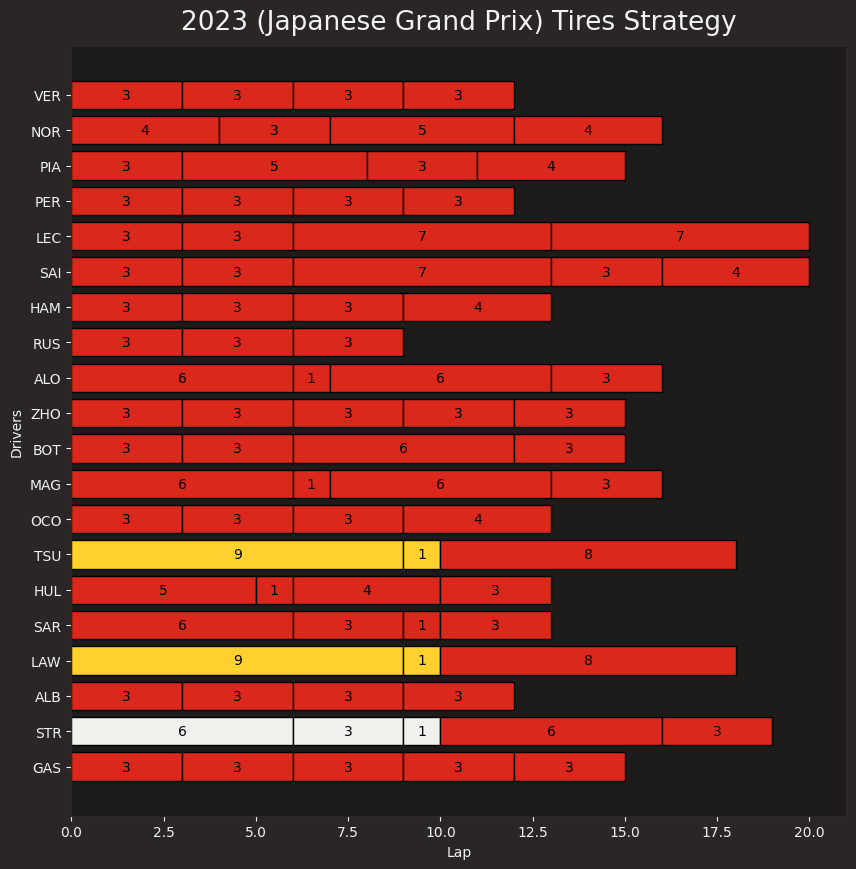

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

for driver in drivers_abr:
    driver_stints = stints.loc[stints["Driver"] == driver]

    previous_stint_end = 0
    for idx, row in driver_stints.iterrows():
        # each row contains the compound name and stint length
        # we can use these information to draw horizontal bars
        plt.barh(
            y=driver,
            width=row["StintLength"],
            left=previous_stint_end,
            color=compound_color[row["Compound"]],
            edgecolor="black",
            fill=True
        )

        # Add the value over the bar
        plt.text(
            x=previous_stint_end + row["StintLength"] / 2,
            y=driver,
            s=str(row["StintLength"]),
            ha='center',
            va='center',
            color='black'  # Set text color to black
        )

        previous_stint_end += row["StintLength"]

# Customize the plot
plt.title('2023 (' + session.event["EventName"] + ') Tires Strategy')
plt.xlabel('Lap')
plt.ylabel('Drivers')
# plt.xticks(range(0, max_lap(laps), 5))
# plt.yticks(range(0, max_gap, 10))
plt.gca().invert_yaxis()

# plt.axvspan(32, 38, facecolor='yellow', alpha=0.3)

# plt.savefig('Graphes/Race/Tires_Strategy.png', dpi=300)
plt.savefig('Graphes/Race/Tires_Strategy.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()



### Speed map 

In [ ]:
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from matplotlib import cm

In [ ]:
driverss = [1,4]

laps = session.laps
# Select the laps from Hamilton and Verstappen
laps_driver1 = laps.pick_driver(driverss[0])
laps_driver2 = laps.pick_driver(driverss[1])

# Get the telemetry data from their fastest lap
fastest_driver1 = laps_driver1.pick_fastest().get_telemetry()
fastest_driver2 = laps_driver2.pick_fastest().get_telemetry()
# Since the telemetry data does not have a variable that indicates the driver, 
# we need to create that column
fastest_driver1['Driver'] = session.get_driver(str(driverss[0]))["Abbreviation"]
fastest_driver2['Driver'] = session.get_driver(str(driverss[1]))["Abbreviation"]

# Merge both lap telemetries so we have everything in one DataFrame
telemetry = fastest_driver1.append(fastest_driver2)

# We want 25 mini-sectors (this can be adjusted up and down)
num_minisectors = 25

# Grab the maximum value of distance that is known in the telemetry
total_distance = telemetry['Distance'].max()

# Generate equally sized mini-sectors 
minisector_length = total_distance / num_minisectors
# Initiate minisector variable, with 0 (meters) as a starting point.
minisectors = [0]

# Add multiples of minisector_length to the minisectors
for i in range(0, (num_minisectors - 1)):
    minisectors.append(minisector_length * (i + 1))

telemetry['Minisector'] = telemetry['Distance'].apply(
    lambda dist: (
        int((dist // minisector_length) + 1)
    )
)

# Calculate avg. speed per driver per mini sector
average_speed = telemetry.groupby(['Minisector', 'Driver'])['Speed'].mean().reset_index()
# Select the driver with the highest average speed
fastest_driver = average_speed.loc[average_speed.groupby(['Minisector'])['Speed'].idxmax()]

# Get rid of the speed column and rename the driver column
fastest_driver = fastest_driver[['Minisector', 'Driver']].rename(columns={'Driver': 'Fastest_driver'})

# Join the fastest driver per minisector with the full telemetry
telemetry = telemetry.merge(fastest_driver, on=['Minisector'])

# Order the data by distance to make matploblib does not get confused
telemetry = telemetry.sort_values(by=['Distance'])

# Convert driver name to integer
telemetry.loc[telemetry['Fastest_driver'] == session.get_driver(str(driverss[0]))["Abbreviation"], 'Fastest_driver_int'] = 1
telemetry.loc[telemetry['Fastest_driver'] == session.get_driver(str(driverss[1]))["Abbreviation"], 'Fastest_driver_int'] = 2

C:\Users\GTR\AppData\Local\Temp\ipykernel_11912\1973517866.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  telemetry = fastest_driver1.append(fastest_driver2)


In [ ]:
lap_time =[]
for i in driverss:
    timedelta = laps.pick_driver(i).pick_fastest()['LapTime']
    # Extract minutes, seconds, and milliseconds
    minutes = timedelta.components.minutes
    seconds = timedelta.components.seconds
    milliseconds = timedelta.components.milliseconds

    # Format the result as mm:ss:ms
    formatted_time = f'{minutes:02}:{seconds:02}:{milliseconds:03}'
    lap_time.append(formatted_time)


legend      WARNING 	No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


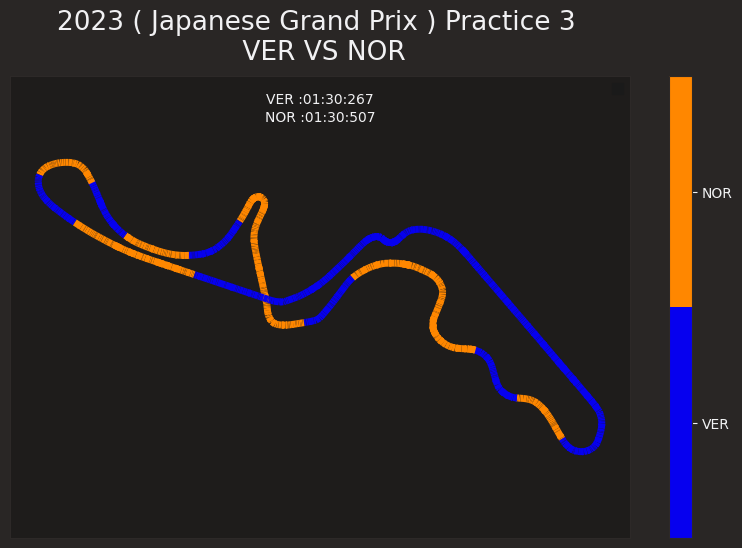

In [ ]:
x = np.array(telemetry['X'].values)
y = np.array(telemetry['Y'].values)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
fastest_driver_array = telemetry['Fastest_driver_int'].to_numpy().astype(float)

custom_colors = [fastf1.plotting.team_color(session.get_driver(str(driverss[0]))["TeamName"]), fastf1.plotting.team_color(session.get_driver(str(driverss[1]))["TeamName"])]
cmap = cm.colors.ListedColormap(custom_colors)

# cmap = cm.get_cmap(["blue","red"], 2)
lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
lc_comp.set_array(fastest_driver_array)
lc_comp.set_linewidth(5)

plt.rcParams['figure.figsize'] = [10, 6]
fig, ax = plt.subplots()

# Hide both x and y-axis
ax.set_xticks([])
ax.set_yticks([])

plt.gca().add_collection(lc_comp)
plt.axis('equal')
# plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)

cbar = plt.colorbar(mappable=lc_comp, boundaries=np.arange(1,4))
cbar.set_ticks(np.arange(1.5, 3))
cbar.set_ticklabels([session.get_driver(str(driverss[0]))["Abbreviation"], session.get_driver(str(driverss[1]))["Abbreviation"]])
plt.title('2023 ( '+session.event["EventName"]+' ) Practice '+str(ses)+' \n '+session.get_driver(str(driverss[0]))["Abbreviation"]+' VS '+session.get_driver(str(driverss[1]))["Abbreviation"])
plt.legend()
# plt.axis('off')
plt.text(0.5, 0.95, session.get_driver(str(driverss[0]))["Abbreviation"]+' :'+lap_time[0], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(0.5, 0.91, session.get_driver(str(driverss[1]))["Abbreviation"]+' :'+lap_time[1], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
# plt.savefig(f"2021_ver_ham_q.png", dpi=300)

plt.show()

In [ ]:
driver1 = laps.pick_driver(1).pick_fastest()[["Sector1Time","Sector2Time" ,"Sector3Time"]]
driver1["S1"] = driver1["Sector1Time"].total_seconds()
driver1["S2"] = driver1["Sector2Time"].total_seconds()
driver1["S3"] = driver1["Sector3Time"].total_seconds()

In [ ]:
driver2 = laps.pick_driver(4).pick_fastest()[["Sector1Time","Sector2Time" ,"Sector3Time"]]
driver2["S1"] = driver2["Sector1Time"].total_seconds()
driver2["S2"] = driver2["Sector2Time"].total_seconds()
driver2["S3"] = driver2["Sector3Time"].total_seconds()

In [ ]:
comparaison = driver2[["S1","S2","S3"]].reset_index(drop=True) - driver1[["S1","S2","S3"]].reset_index(drop=True)

In [ ]:
comparaison

0   -0.054
1    0.033
2    0.261
dtype: object